# Optical flow timelapse stabilizer tutorial notebook

See also the companion blog post at https://yue-here.github.io/opticalflow/

Timelapse footage is sometimes shaky as show below, due to thermal expansion or the camera being placed on an unstable surface.

![unstabilized](unstabilized.gif)

A previous blender VFX stabilization trace for a similar clip gives this pattern for a vertical feature movement:

![blender trace](example.png)

However, in the current video, there is no consistent feature to track throughout the footage. Here we develop a stabilisation method based on optical flow as implemented in OpenCV.

## Define basic functions

First we define some basic functions used in this notebook.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def compute_dense_optical_flow(prev_img_path, next_img_path):
    prev_frame = cv2.imread(prev_img_path, cv2.IMREAD_GRAYSCALE)
    next_frame = cv2.imread(next_img_path, cv2.IMREAD_GRAYSCALE)
    flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

def draw_hsv_color_wheel(radius=50, saturation=255):
    wheel = np.ones((radius*2, radius*2, 3), np.uint8) * 255
    center = radius
    for y in range(-radius, radius):
        for x in range(-radius, radius):
            distance = np.sqrt(x**2 + y**2)
            if distance < radius:
                angle = np.arctan2(y, x)
                hue = int((angle + np.pi) / (2 * np.pi) * 180)
                wheel[center+y, center+x] = [hue, saturation, min(255, max(0, int(distance / radius * 255)))]
    wheel_bgr = cv2.cvtColor(wheel, cv2.COLOR_HSV2BGR)
    return wheel_bgr

def plot_histogram(data, title, xlabel, ylabel, bins=256, range=None):
    plt.hist(data.ravel(), bins=bins, range=range)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def filter_values(flow):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask = (magnitude > 3) # Filter out low magnitude values that are highly represented
    filtered_magnitude = magnitude[mask]
    filtered_angle_deg = np.degrees(angle[mask])
    return filtered_magnitude, filtered_angle_deg

def plotting(prev_img_path, next_img_path):
    flow = compute_dense_optical_flow(prev_img_path, next_img_path)
    filtered_magnitude, filtered_angle_deg = filter_values(flow)

    # Separate the plotting of magnitude and angle with their histograms
    plt.figure(figsize=(12, 10))  # Adjust the figure size for better layout

    # Flow Magnitude and its Histogram
    plt.subplot(2, 2, 1)  # Use 2 rows, 2 columns, position 1
    magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mag_norm = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    plt.imshow(mag_norm, cmap='gray')
    plt.colorbar()
    plt.title('Flow Magnitude')

    plt.subplot(2, 2, 2)  # Use 2 rows, 2 columns, position 2
    plot_histogram(filtered_magnitude, 'Filtered Histogram of Flow Magnitude', 'Magnitude', 'Frequency')

    # Flow Angle and its Histogram
    plt.subplot(2, 2, 3)  # Use 2 rows, 2 columns, position 3
    _, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    angle_deg = np.degrees(angle)  # Convert angle to degrees
    plt.imshow(angle_deg, cmap='hsv', vmin=0, vmax=360)  # Ensure correct range for angle visualization
    plt.colorbar()
    plt.title('Flow Angle')

    plt.subplot(2, 2, 4)  # Use 2 rows, 2 columns, position 4
    plot_histogram(filtered_angle_deg, 'Filtered Histogram of Flow Angle', 'Angle (degrees)', 'Frequency', bins=360, range=[0, 360])

    plt.tight_layout()
    plt.show()

The color wheel maps the direction shift orientations for the plots below

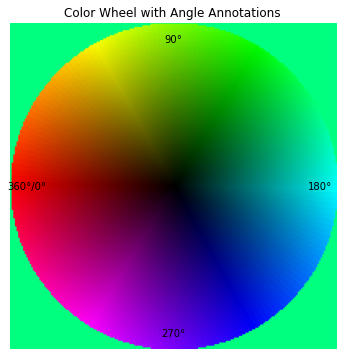

In [8]:
def draw_hsv_color_wheel(radius=50, saturation=255):
    wheel = np.ones((radius*2, radius*2, 3), np.uint8) * 255
    center = radius
    for y in range(-radius, radius):
        for x in range(-radius, radius):
            distance = np.sqrt(x**2 + y**2)
            if distance < radius:
                angle = np.arctan2(y, x)
                hue = int((angle + np.pi) / (2 * np.pi) * 180)
                wheel[center+y, center+x] = [hue, saturation, min(255, max(0, int(distance / radius * 255)))]
    wheel_bgr = cv2.cvtColor(wheel, cv2.COLOR_HSV2BGR)
    return wheel_bgr

# Generate the color wheel
color_wheel = draw_hsv_color_wheel(radius=100)  # Increased radius for better visibility

# Plot the color wheel with angle annotations
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(color_wheel, cv2.COLOR_BGR2RGB))
plt.title('Color Wheel with Angle Annotations')

# Calculate positions for the angle annotations
center = 100  # Update this if you change the radius in draw_hsv_color_wheel
offset = 10  # Offset from the edge for placing text

# Angles and their corresponding labels
angles = [180, 270, 360, 90]
labels = ['180°', '270°', '360°/0°', '90°']

for angle, label in zip(angles, labels):
    # Convert angles to radians and calculate text positions
    rad = np.deg2rad(angle-180)  # Adjusting to start from the top
    x = center + (center - offset) * np.cos(rad)
    y = center + (center - offset) * np.sin(rad)
    
    # Plot text
    plt.text(x, y, label, horizontalalignment='center', verticalalignment='center', color='black')

plt.axis('off')
plt.show()


## Tests of different cases

Here we test the main transition types.

Two frames over a shift (day) - the most straightforward shift case

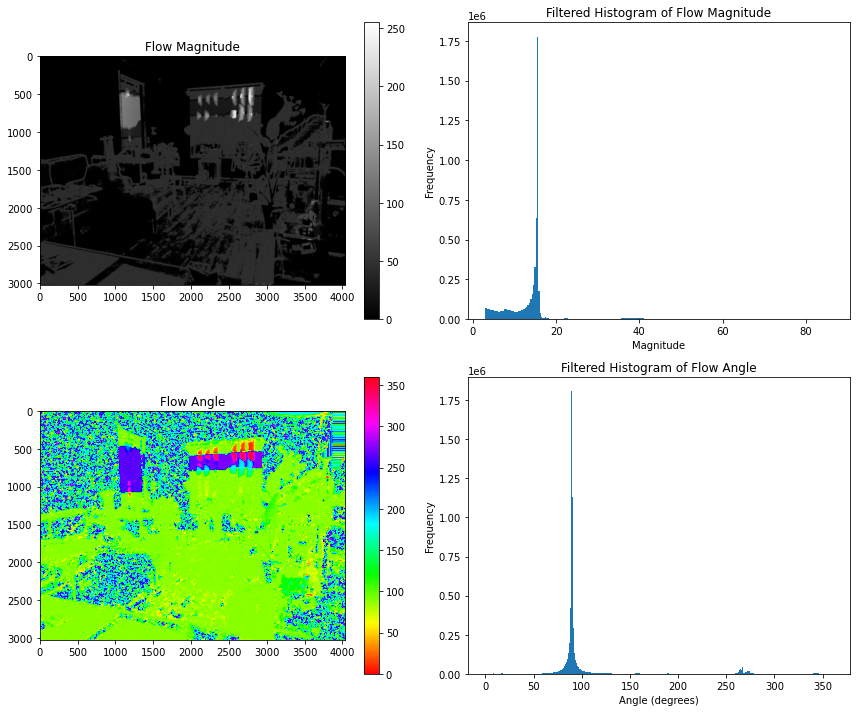

In [9]:
plotting('data/00008.jpg', 'data/00009.jpg')

Two frames over a shift (day), opposite direction

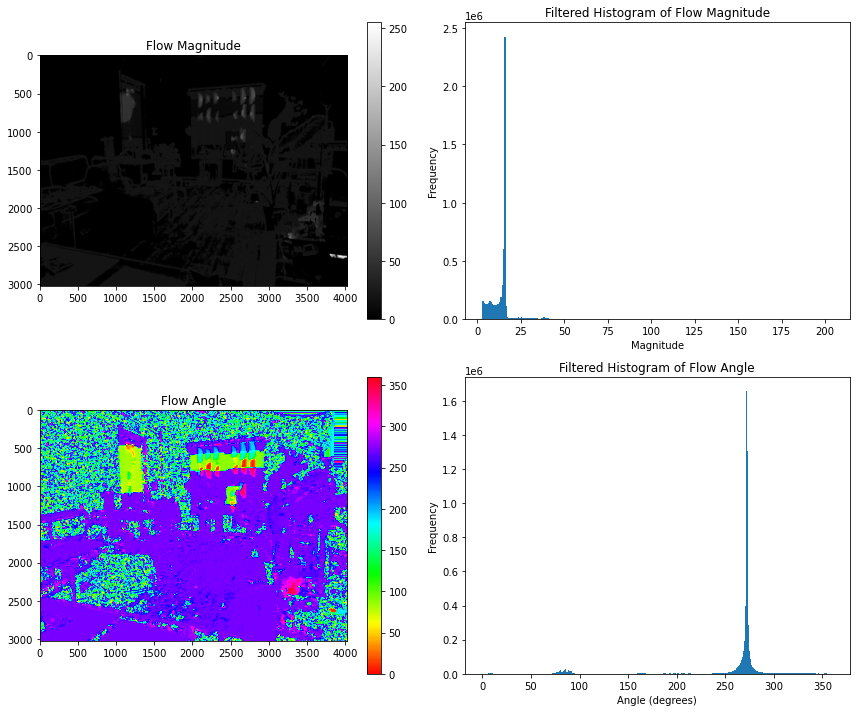

In [10]:
plotting('data/00009.jpg', 'data/00010.jpg')

Two similar frames - no peak in flow magnitude histogram

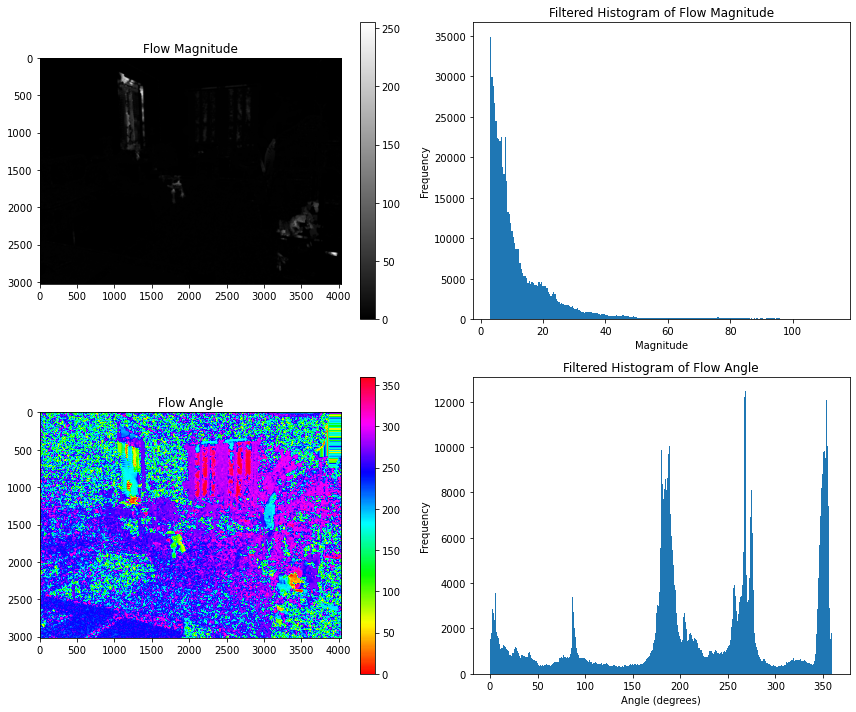

In [11]:
plotting('data/00006.jpg', 'data/00007.jpg')

Brightness change with no shift (day-night, lights off)

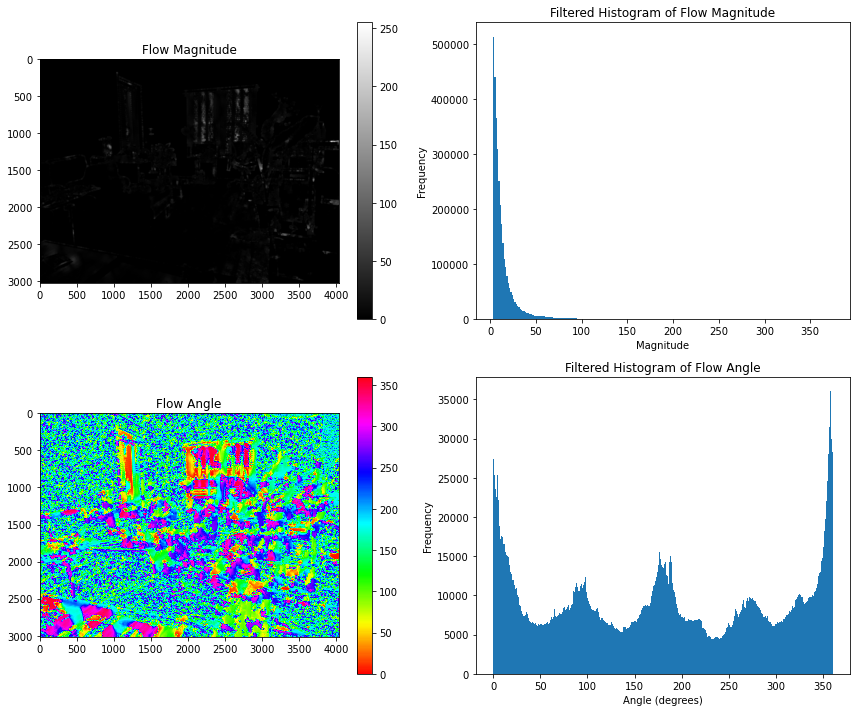

In [12]:
plotting('data/00018.jpg', 'data/00019.jpg')

Both brightness change and shift (early morning)

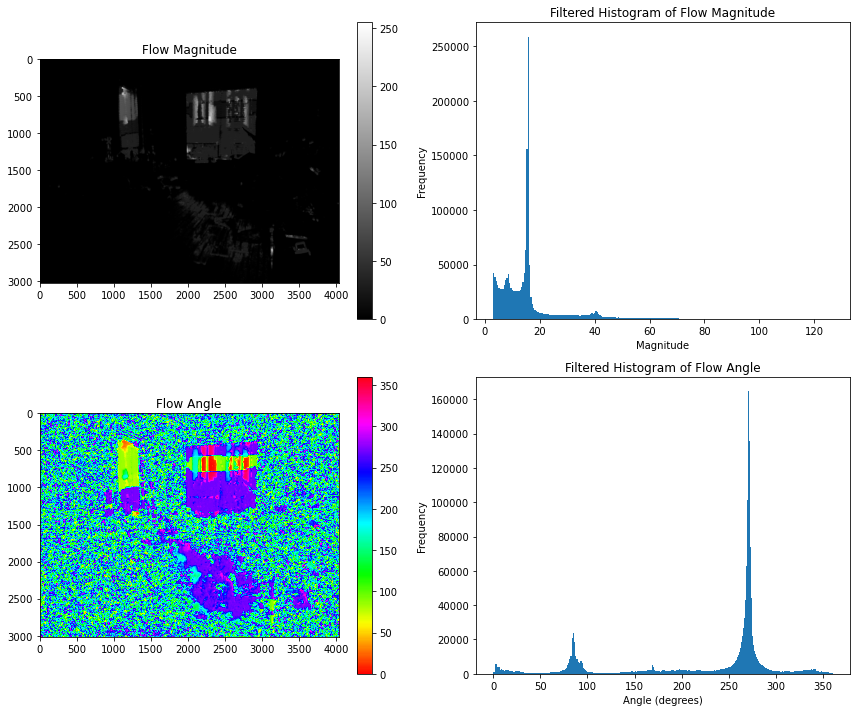

In [13]:
plotting('data/00061.jpg', 'data/00062.jpg')

Two frames over a shift (night - much lower intensities)

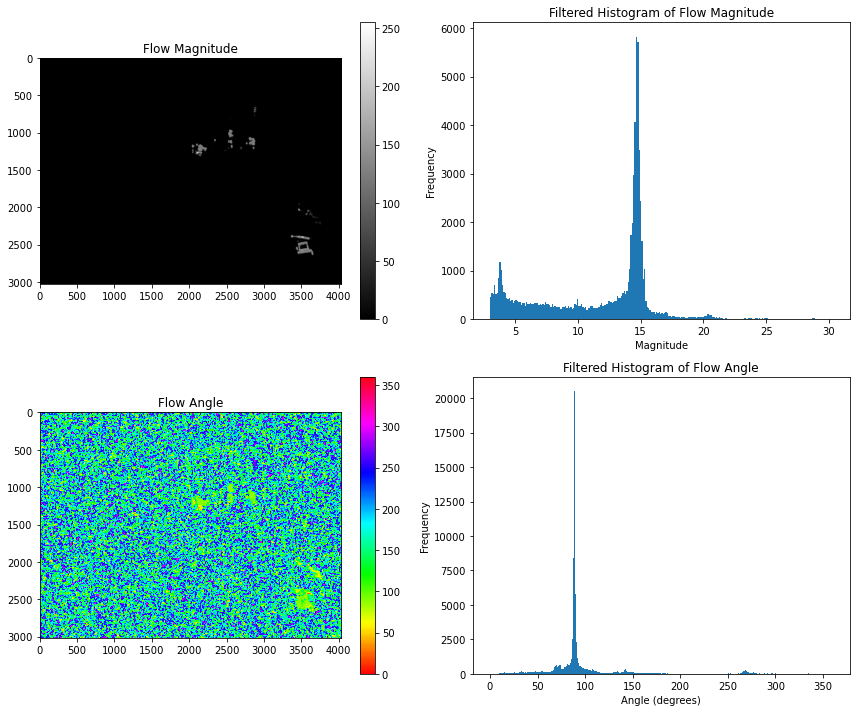

In [14]:
plotting('data/00055.jpg', 'data/00056.jpg')

### Conclusions
The position and intensity of the highest peak in magnitude and angle are likely to be enough to stabilize the video, if it can be shown to be a real shift. Errors of 1-2 pixels are not very perceptible in the final outcome.

## Batch calculation
Now we implement the batch calculation over multiple frames

First, check if OpenCL is supported for GPU acceleration.

In [15]:
import cv2

if cv2.ocl.haveOpenCL():
    print("OpenCL is supported")
else:
    print("OpenCL is not supported")

cv2.ocl.setUseOpenCL(True)

OpenCL is supported


Implement batch calculation code with accelerations. We only save histogram peaks from each optical flow calculation to save space. For magnitude histograms without peaks, we can set the value to 0 if it's the first entry in the array. We can filter out low magnitude values as well so that the low-magnitude noise doesn't drown out any peaks.

In [2]:
import os
import csv
from tqdm import tqdm

def compute_dense_optical_flow(prev_frame, next_frame):
    flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow.get()  # Convert UMat result to np.ndarray for further processing

def find_histogram_peak(data, bins=256, default_range=(0, 256)):
    # Adjust to use default_range if data is empty
    hist_range = default_range if data.size == 0 else (default_range[0], max(default_range[1], np.max(data)))
    hist, bin_edges = np.histogram(data.ravel(), bins=bins, range=hist_range)
    max_freq_index = np.argmax(hist)
    if max_freq_index == 0 and hist[0] > hist[1]:
        return 0, 0  # Return 0 if the peak is at the minimum value - omit cases where decay is higher than peak
    peak_freq = hist[max_freq_index]
    peak_value = (bin_edges[max_freq_index] + bin_edges[max_freq_index + 1]) / 2
    return peak_freq, peak_value

def filter_values(flow):
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mask = magnitude > 1  # Filter magnitudes greater than n. Smaller values filter out smaller shifts too as they are dominated
    filtered_magnitude = magnitude[mask]
    filtered_angle_deg = np.degrees(angle[mask])
    return filtered_magnitude, filtered_angle_deg

def process_frame_pairs(start_frame, end_frame, directory='data', output_csv='output.csv'):
    with open(output_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Frame Index Pair', 'Magnitude Peak Frequency', 'Magnitude Peak Value', 'Angle Peak Frequency', 'Angle Peak Value'])

        prev_frame = None

        for i in tqdm(range(start_frame, end_frame + 1)):
            current_img_path = os.path.join(directory, f'{i:05d}.jpg')

            if not os.path.exists(current_img_path):
                print(f"Skipping: {current_img_path} does not exist.")
                continue

            current_frame = cv2.UMat(cv2.imread(current_img_path, cv2.IMREAD_GRAYSCALE))

            if prev_frame is not None:
                flow = compute_dense_optical_flow(prev_frame, current_frame)
                filtered_magnitude, filtered_angle_deg = filter_values(flow)

                # Use a default range for histogram if filtered_magnitude is empty
                default_range = (1, 255)
                if filtered_magnitude.size > 0:
                    mag_range = (1, np.max(filtered_magnitude))
                else:
                    mag_range = default_range  # Avoid error with empty array
                
                mag_peak_freq, mag_peak_value = find_histogram_peak(filtered_magnitude, bins=256, default_range=mag_range)
                angle_peak_freq, angle_peak_value = find_histogram_peak(filtered_angle_deg, bins=360, default_range=(0, 360))

                writer.writerow([f"{i-1}-{i}", mag_peak_freq, mag_peak_value, angle_peak_freq, angle_peak_value])

            prev_frame = current_frame

# Example usage
# Adjust start_frame, end_frame as necessary
# process_frame_pairs(1, 10, 'data', 'output.csv')


In [3]:
# Run processing
working_file = 'tutorial.csv'
process_frame_pairs(1, 100, 'data', working_file)

100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Visualise results

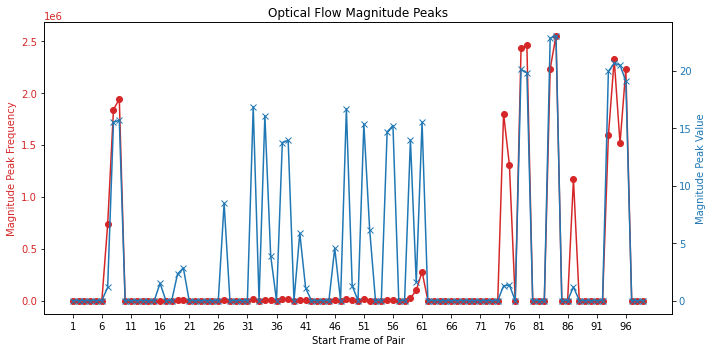

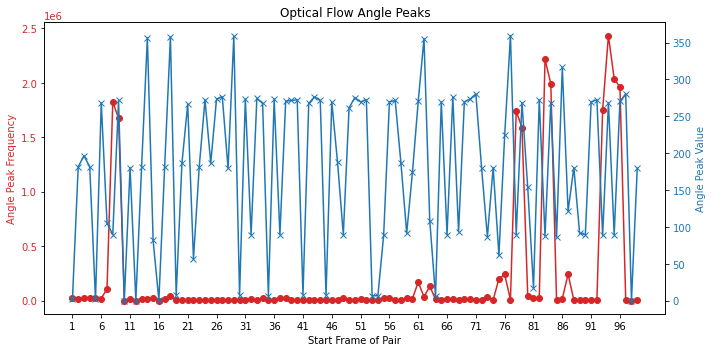

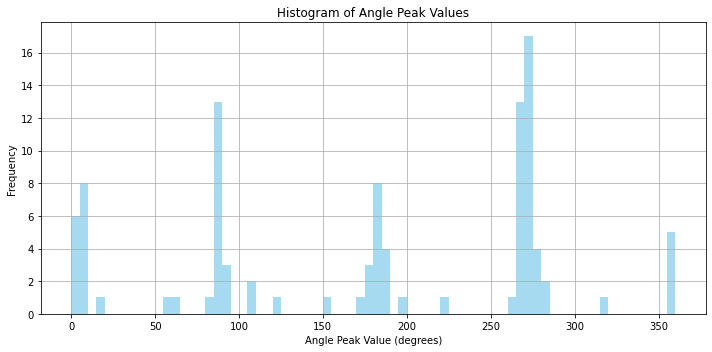

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV data into a DataFrame
data = pd.read_csv(working_file)

# Split the 'Frame Index Pair' to get the starting frame of each pair for plotting
data['Start Frame'] = data['Frame Index Pair'].apply(lambda x: int(x.split('-')[0]))

# Determine the range for x-ticks based on the frame data
x_ticks = range(min(data['Start Frame']), max(data['Start Frame']) + 1, 5)

# Function to plot Frequency and Value on different y-axes for Magnitude and Angle
def plot_with_dual_axes(data, x_ticks, y1_label, y2_label, y1_data, y2_data, title):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:red'
    ax1.set_xlabel('Start Frame of Pair')
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(data['Start Frame'], data[y1_data], label=y1_label, color=color, marker='o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_xticks(x_ticks)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)
    ax2.plot(data['Start Frame'], data[y2_data], label=y2_label, color=color, marker='x')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(title)
    fig.tight_layout()

# Plotting Magnitude and Angle Peaks with separate y-axes
plot_with_dual_axes(data, x_ticks, 'Magnitude Peak Frequency', 'Magnitude Peak Value', 'Magnitude Peak Frequency', 'Magnitude Peak Value', 'Optical Flow Magnitude Peaks')
plot_with_dual_axes(data, x_ticks, 'Angle Peak Frequency', 'Angle Peak Value', 'Angle Peak Frequency', 'Angle Peak Value', 'Optical Flow Angle Peaks')

# Plotting the histogram of Angle Peak Values
plt.figure(figsize=(10, 5))
plt.hist(data['Angle Peak Value'], bins=72, range=[0, 360], color='skyblue', alpha=0.75)
plt.xlabel('Angle Peak Value (degrees)')
plt.ylabel('Frequency')
plt.title('Histogram of Angle Peak Values')
plt.grid(True)
plt.tight_layout()
plt.show()

This data suggests that we can filter by angle (within 5 degrees of 90/270) and magnitude (very small shifts 1-2 might be noise) to extract relevant values.

In [14]:
import pandas as pd
import numpy as np

# Load the CSV data into a DataFrame
data = pd.read_csv(working_file)

# Applying filters with proper grouping of conditions
filtered_data = data[
    (
        ((data['Angle Peak Value'] >= 85) & (data['Angle Peak Value'] <= 95)) | 
        ((data['Angle Peak Value'] >= 265) & (data['Angle Peak Value'] <= 275))
    ) & 
    (data['Magnitude Peak Value'] > 3) # 10 doesn't get peaks in the dark
]

# Further filter and clean the data
cleaned_data = filtered_data.copy()

# Extract 'Frame' as the second number in "Frame Index Pair"
cleaned_data['Frame'] = cleaned_data['Frame Index Pair'].apply(lambda x: int(x.split('-')[1]))

# Round 'Magnitude Peak Value' to the nearest integer
cleaned_data['Magnitude Peak Value'] = cleaned_data['Magnitude Peak Value'].round().astype(int)

# Adjust 'Angle Peak Value' to the nearest value of 90 or 270
def adjust_angle(angle):
    if abs(angle - 90) < abs(angle - 270):
        return 90
    else:
        return 270

cleaned_data['Angle Peak Value'] = cleaned_data['Angle Peak Value'].apply(adjust_angle)

# Select only the required columns for the new DataFrame
cleaned_dataframe = cleaned_data[['Frame', 'Magnitude Peak Value', 'Angle Peak Value']]

print(cleaned_dataframe)

    Frame  Magnitude Peak Value  Angle Peak Value
7       9                    16                90
8      10                    16               270
31     33                    17                90
33     35                    16               270
36     38                    14                90
37     39                    14               270
39     41                     6               270
45     47                     5               270
47     49                    17                90
50     52                    15               270
51     53                     6               270
54     56                    15                90
55     57                    15               270
58     60                    14                90
60     62                    16               270
77     79                    20                90
78     80                    20               270
82     84                    23                90
83     85                    23               270


Now iteratively compute the relative shifts from the origin frame.

In [15]:
# Initialize a list to hold the computed values
computed_values = []

# Initialize the starting value
previous_value = 0

# Iterate through each row of the DataFrame
for index, row in cleaned_dataframe.iterrows():
    if row['Angle Peak Value'] == 90:
        new_value = previous_value - row['Magnitude Peak Value']
    elif row['Angle Peak Value'] == 270:
        new_value = previous_value + row['Magnitude Peak Value']
    else:
        new_value = previous_value  # Default case, if needed
    
    # Append the new value to the list
    computed_values.append(new_value)
    
    # Update the previous value for the next iteration
    previous_value = new_value

# Add the computed values as a new column to the DataFrame
cleaned_dataframe['Computed Column'] = computed_values

# Re-index cleaned_dataframe
cleaned_dataframe = cleaned_dataframe.reset_index(drop=True)

print(cleaned_dataframe)

    Frame  Magnitude Peak Value  Angle Peak Value  Computed Column
0       9                    16                90              -16
1      10                    16               270                0
2      33                    17                90              -17
3      35                    16               270               -1
4      38                    14                90              -15
5      39                    14               270               -1
6      41                     6               270                5
7      47                     5               270               10
8      49                    17                90               -7
9      52                    15               270                8
10     53                     6               270               14
11     56                    15                90               -1
12     57                    15               270               14
13     60                    14                90             

<ipython-input-15-aa3c83f36c10>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataframe['Computed Column'] = computed_values


Calculate the window size based on min and max shifts

In [16]:
# Obtain min and max Computed Column values from the DataFrame
min_val = cleaned_dataframe['Computed Column'].min()
max_val = cleaned_dataframe['Computed Column'].max()
range_val = max_val - min_val
# Print the min and max values
print(f"min:{min_val}, max:{max_val}, range:{range_val}")

min:-17, max:17, range:34


Write a simple cropping function that we can apply later

In [19]:
from PIL import Image

def crop_image_top_bottom(image_path, n_top, n_bottom):
    # Open the image
    with Image.open(image_path) as img:
        # Calculate the new dimensions
        width, height = img.size
        new_top = n_top
        new_bottom = height - n_bottom

        # Ensure the new dimensions are valid
        if new_top >= new_bottom:
            raise ValueError("The top crop must be less than the height of the image minus the bottom crop.")

        # Crop the image
        cropped_img = img.crop((0, new_top, width, new_bottom))

        # Create the 'cropped' subfolder if it doesn't exist
        cropped_folder_path = os.path.join(os.path.dirname(image_path), 'cropped')
        os.makedirs(cropped_folder_path, exist_ok=True)

        # Save the cropped image in the 'cropped' subfolder
        cropped_image_path = os.path.join(cropped_folder_path, os.path.basename(image_path))
        cropped_img.save(cropped_image_path)

        # print(f"Cropped image saved to {cropped_image_path}")

Batch crop a whole folder

In [20]:
import glob

# Get the list of all frame filenames in the directory
frame_files = sorted(glob.glob('data/*.jpg'))

# Determine the maximum frame number from the filenames
max_frame_number = int(frame_files[-1].split('\\')[-1].split('.')[0]) if frame_files else 0

print(f"Max frame #: {max_frame_number}")

# Process frames before the first frame in cleaned_dataframe
first_frame = cleaned_dataframe['Frame'].iloc[0]

# Pre-calculate n_top and n_bottom based on min_val and max_val
n_top_, n_bottom_ = 0, 0

# Case 1 - straddle
if min_val < 0 and max_val > 0:
    n_top_ = max_val
    n_bottom_ = range_val - n_top_

# Case 2 - positive
if max_val > 0 and min_val > 0:
    n_top_ = max_val
    n_bottom_ = 0

# Case 3 - negative
if min_val < 0 and max_val < 0:
    n_top_ = 0
    n_bottom_ = abs(min_val)

for frame_number in range(1, first_frame):
    image_path = f'data/{frame_number:05d}.jpg'
    crop_image_top_bottom(image_path, n_top_, n_bottom_)

# Process each frame according to cleaned_dataframe
for index, row in tqdm(cleaned_dataframe.iterrows()):
    start_frame = row['Frame']
    # Determine end_frame based on the next frame in cleaned_dataframe or the last available frame
    if index + 1 < len(cleaned_dataframe):
        end_frame = cleaned_dataframe['Frame'].iloc[index + 1]
    else:
        end_frame = max_frame_number + 1  # +1 because the range end is exclusive

    for frame_number in range(start_frame, end_frame):  # end_frame is exclusive
        n_top, n_bottom = 0, 0

        if row['Computed Column'] < 0:
            n_top = n_top_ + abs(row['Computed Column'])
            n_bottom = n_bottom_ - abs(row['Computed Column'])

        elif row['Computed Column'] > 0:
            n_top = n_top_ - row['Computed Column']
            n_bottom = n_bottom_ + row['Computed Column']

        # Default values if 0
        if row['Computed Column'] == 0:
            n_top, n_bottom = n_top_, n_bottom_
        
        image_path = f'data/{frame_number:05d}.jpg'
        crop_image_top_bottom(image_path, n_top, n_bottom)

Max frame #: 100


23it [00:30,  1.34s/it]


## Results

![stabilized](stabilized.gif)